# Calculate NDVI

The Normalized Difference Vegetation Index (NDVI) is a standard calculation frequently used to analyze ecological remote sensing data. In short, the NDVI indicates whether the remotely-sensed target contains live green vegetation. When sunlight strikes objects, certain wavelengths of this spectrum are absorbed and other wavelengths are reflected. The pigment chlorophyll in plant leaves strongly absorbs visible light (with wavelengths in the range of 400-700 nm) for use in photosynthesis. The cell structure of the leaves, however, strongly reflects near-infrared light (wavelengths ranging from 700 - 1100 nm). Plants reflect up to 60% more light in the near infrared portion of the spectrum than they do in the green portion of the spectrum. By comparing the ratio of Near Infrared (NIR) to Visible (VIS) bands in hyperspectral data, we can obtain a quick look at vegetation in the region of interest. NDVI is a normalized measure of the difference between reflectance at near infrared and visible bands of the electromagnetic spectrum. 

The formula for NDVI is: $$NDVI = \frac{(NIR - VIS)}{(NIR+ VIS)}$$

<p>
<img src="files/ndvi_tree.png" style="width: 250px;"/>
<center><font size="2">Figure: (Wu et al. 2014)</font></center>
<center><font size="2">https://www.researchgate.net/figure/266947355_fig1_Figure-1-Green-vegetation-left-absorbs-visible-light-and-reflects-near-infrared-light</font></center>
</p>

### Load neon_aop.py module

In [1]:
# %load ../neon_aop.py
"""
Created on Wed Feb  8 10:06:25 2017

@author: bhass
"""

# %load ./neon_aop_python.py
"""
Created on Mon Feb  6 16:36:10 2017

@author: bhass
"""

import numpy as np
import matplotlib.pyplot as plt
import h5py, gdal, osr, copy

#list_dataset lists the names of datasets in an hdf5 file
#call syntax: f.visititems(list_dataset)
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

#ls_dataset displays the name, shape, and type of datasets in hdf5 file
#call syntax: f.visititems(ls_dataset)
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)

def h5refl2array(refl_filename,sitename):

    hdf5_file = h5py.File(refl_filename,'r')
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create metadata dictionary 
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value 
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]

    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) 
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    #xMax = left corner + (# of columns * resolution)
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth']))
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) 
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax

    return reflArray, metadata, wavelengths
    
def extract_raw_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    return bandArray 

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned   
    
def subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    bandSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],bandIndex-1].astype(np.float)
    bandSubCleaned[bandSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandSubCleaned = bandSubCleaned/reflArray_metadata['scaleFactor']
    return bandSubCleaned 

def subset_clean_refl(reflArray,reflArray_metadata,clipIndex):
    reflSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],:].astype(np.float)
    reflSubCleaned[reflSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    reflSubCleaned = reflSubCleaned/reflArray_metadata['scaleFactor']
    return reflSubCleaned 

# def plot_flightline_band(band_array,refl_extent,size=(6,6),title='',cmap_title='',colormap='spectral'):
#     fig = plt.figure(figsize=size)
#     plot = plt.imshow(band_array,extent=refl_extent); 
#     cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
#     cbar.set_label(cmap_title,rotation=90,labelpad=20)
#     plt.title(title); ax = plt.gca(); 
#     ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
#     rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

def plot_band_array(band_array,refl_extent,title='',cmap_title='',colormap='spectral'):
    plot = plt.imshow(band_array,extent=refl_extent); 
    cbar = plt.colorbar(plot); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
def array2raster(newRaster,reflBandArray,reflArray_metadata,epsg): 
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg) #4326 = WGS84
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    #Define a dictionary for the index extent (ind_ext):
    
    h5rows = h5Extent['yMax'] - h5Extent['yMin']
    h5cols = h5Extent['xMax'] - h5Extent['xMin']    
    
    ind_ext = {}
    ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
    ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
    ind_ext['yMax'] = round(h5rows - (clipExtent['yMin']-h5Extent['yMin'])/xscale)
    ind_ext['yMin'] = round(h5rows - (clipExtent['yMax']-h5Extent['yMin'])/yscale)

    return ind_ext
    
def stack_bands(reflArray,reflArray_metadata,bands):
    band_clean_dict = {}
    band_clean_names = []

    stackedArray = np.zeros((reflArray.shape[0],reflArray.shape[1],len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = extract_clean_band(reflArray,reflArray_metadata,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray
    
def stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    band_clean_dict = {}
    band_clean_names = []

    subArray_rows = clipIndex['yMax'] - clipIndex['yMin']
    subArray_cols = clipIndex['xMax'] - clipIndex['xMin']
    
    stackedArray = np.zeros((subArray_rows,subArray_cols,len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = subset_clean_band(reflArray,reflArray_metadata,clipIndex,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

## Read in SERC Flightline & Subset

In [2]:
#Define inputs
filename = '../data/SERC/hyperspectral/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5'
sercRefl, sercRefl_md, wavelengths = h5refl2array(filename,'SERC')

clipExtDict = {}
clipExtDict['xMin'] = 367400.
clipExtDict['xMax'] = 368100.
clipExtDict['yMin'] = 4305750.
clipExtDict['yMax'] = 4306350.

clipExtent = (clipExtDict['xMin'],clipExtDict['xMax'],clipExtDict['yMin'],clipExtDict['yMax'])

clipIndex = calc_clip_index(clipExtDict,sercRefl_md['ext_dict'])

sercReflSubset = subset_clean_refl(sercRefl,sercRefl_md,clipIndex)

## Stack NIR and VIS bands

Now that we have uploaded all the required functions, we can calculate NDVI and plot it. 
We will compute NDVI using bands 58 and 90. These correspond to wavelength ranges of:
$$band 60: \lambda_{VIS} = 666.6-671.6 nm$$ $$band 83: \lambda_{NIR} = 826.8-831.9 nm$$.

In [3]:
#Select bands to be used in the NDVI calculation
ndvi_bands = (58,90) #NIR and VIS (Red) bands

#Check the center wavelengths that these bands represent
band_width = wavelengths.value[1]-wavelengths.value[0]

print('band 58 wavelength range: ' + str(round(wavelengths.value[57]-band_width/2,2)) 
      + '-' + str(round(wavelengths.value[57]+band_width/2,2)) + ' nm')
print('band 90 wavelength range: ' + str(round(wavelengths.value[89]-band_width/2,2)) 
      + '-' + str(round(wavelengths.value[89]+band_width/2,2)) + ' nm')

#Use the stack_subset_bands function to create a stack of the subsetted red and NIR bands needed to calculate NDVI

ndvi_stack = stack_subset_bands(sercRefl,sercRefl_md,ndvi_bands,clipIndex)

band 58 wavelength range: 666.59-671.6 nm
band 90 wavelength range: 826.84-831.85 nm


# Calculate NDVI & Plot

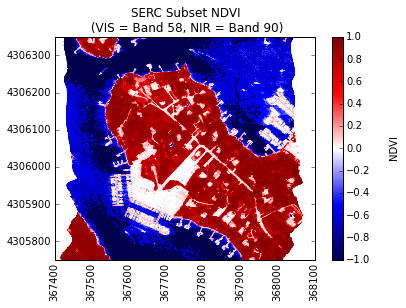

In [4]:
vis = ndvi_stack[:,:,0].astype(float)
nir = ndvi_stack[:,:,1].astype(float)

#the numpy divide function divides the array element by element
# if the denominator (nir+vis) = 0, set the answer to be zero
ndvi = np.divide((nir-vis),(nir+vis),out=np.zeros_like(nir-vis),where=(nir+vis)!=0)
# print(ndvi)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plot_band_array(ndvi,clipExtent,title='SERC Subset NDVI \n (VIS = Band 58, NIR = Band 90)',cmap_title='NDVI',colormap='seismic')
# plot_band_array(ndvi,clipExtent,'NDVI (VIS = Band 58, NIR = Band 90)')

# Extract Spectra Using Masks

In the second part of this tutorial, we will learn how to extract the spectra of pixels whose NDVI exceeds a specified threshold value. There are several ways to do this using `numpy`, including the mask functions `numpy.ma`, as well as `numpy.where` and finally using `boolean` indexing. 

To start, lets copy the NDVI calculated above and use booleans to create an array only containing NDVI > 0.6.

Mean NDVI > 0.6: 0.87


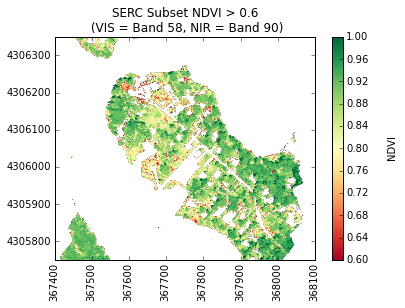

In [5]:
import copy
ndvi_gtpt6 = copy.copy(ndvi)
ndvi_gtpt6[ndvi<0.6] = np.nan  #set all pixels with NDVI < 0.6 to nan, keeping only values > 0.6
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt6),2))

plot_band_array(ndvi_gtpt6,clipExtent,title='SERC Subset NDVI > 0.6 \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',colormap='RdYlGn')

# Function to calculate the mean spectra for reflectance values thresholed by NDVI using `numpy.ma`:

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [7]:
## FOR SOME REASON THIS FUNCTION DOESN'T WORK WHEN THE NDVI THRESHOLD IS ZERO ?? --> MEAN_MASKED_REFL = NaN
## BUT SEEMS TO WORK OTHERWISE

import numpy.ma as ma
def calculate_mean_masked_spectra(reflArray,ndvi,ndvi_threshold,ineq='>'):
    
    mean_masked_refl = np.zeros(reflArray.shape[2])
    
    for i in np.arange(reflArray.shape[2]):
        refl_band = reflArray[:,:,i]
        
        if ineq == '>':
            ndvi_mask = ma.masked_where(ndvi<ndvi_threshold,ndvi)
        
        elif ineq == '<':
            ndvi_mask = ma.masked_where(ndvi>ndvi_threshold,ndvi)
                
        else:
            print('ERROR: Invalid inequality. Enter < or >')
            
        masked_refl = ma.MaskedArray(refl_band,mask=ndvi_mask.mask)
        mean_masked_refl[i] = ma.mean(masked_refl)
            
    return mean_masked_refl

In [8]:
sercRefl_ndvi_gt0 = calculate_mean_masked_spectra(sercReflSubset,ndvi,0.) ## > 0 DOESN'T WORK ??
sercRefl_ndvi_gtpt05 = calculate_mean_masked_spectra(sercReflSubset,ndvi,0.05)
sercRefl_ndvi_gtpt6 = calculate_mean_masked_spectra(sercReflSubset,ndvi,0.6)
sercRefl_ndvi_gtpt95 = calculate_mean_masked_spectra(sercReflSubset,ndvi,0.95)

sercRefl_ndvi_lt0 = calculate_mean_masked_spectra(sercReflSubset,ndvi,-0.,ineq='<') ## < 0 DOESN'T WORK??
sercRefl_ndvi_ltnpt05 = calculate_mean_masked_spectra(sercReflSubset,ndvi,-0.05,ineq='<')

import pandas

#Remove water vapor band windows & last 10 bands 
w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

nan_ind = np.argwhere(np.isnan(w))

sercRefl_ndvi_gt0[nan_ind] = np.nan
sercRefl_ndvi_gtpt05[nan_ind] = np.nan
sercRefl_ndvi_gtpt6[nan_ind] = np.nan
sercRefl_ndvi_gtpt95[nan_ind] = np.nan
sercRefl_ndvi_lt0[nan_ind] = np.nan
sercRefl_ndvi_ltnpt05[nan_ind] = np.nan

#Create dataframe with masked NDVI mean spectra
sercSpectra_ndvi_df = pandas.DataFrame()
sercSpectra_ndvi_df['wavelength'] = w
sercSpectra_ndvi_df['mean_refl_ndvi_gt0'] = sercRefl_ndvi_gt0 ##?? 
sercSpectra_ndvi_df['mean_refl_ndvi_gtpt05'] = sercRefl_ndvi_gtpt05
sercSpectra_ndvi_df['mean_refl_ndvi_gtpt6'] = sercRefl_ndvi_gtpt6
sercSpectra_ndvi_df['mean_refl_ndvi_gtpt95'] = sercRefl_ndvi_gtpt95
sercSpectra_ndvi_df['mean_refl_ndvi_lt0'] = sercRefl_ndvi_lt0
sercSpectra_ndvi_df['mean_refl_ndvi_ltnpt05'] = sercRefl_ndvi_ltnpt05

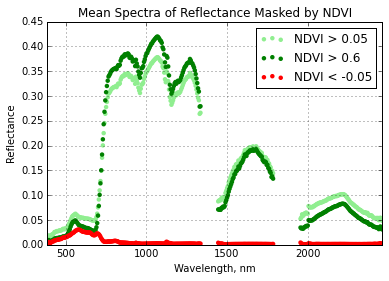

In [9]:
# sercSpectra_ndvi_df.plot(x='wavelength',y='mean_refl_ndvi_gt0',label='NDVI > 0',legend=True,color='yellow',edgecolor='none',kind='scatter');
# ax = plt.gca();
sercSpectra_ndvi_df.plot(x='wavelength',y='mean_refl_ndvi_gtpt05',label='NDVI > 0.05',legend=True,color='lightgreen',edgecolor='none',kind='scatter');
ax = plt.gca();
sercSpectra_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_gtpt6',color='green',edgecolor='none',kind='scatter',label='NDVI > 0.6',legend=True);
sercSpectra_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_ltnpt05',color='red',edgecolor='none',kind='scatter',label='NDVI < -0.05',legend=True);

ax.set_title('Mean Spectra of Reflectance Masked by NDVI')
ax.set_xlim([np.nanmin(w),np.nanmax(w)]); 
ax.set_ylim(0,0.45)
ax.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax.grid('on'); 

## References

Wu C-D, McNeely E, Cedeño-Laurent JG, Pan W-C, Adamkiewicz G, Dominici F, et al. (2014) Linking Student Performance in Massachusetts Elementary Schools with the “Greenness” of School Surroundings Using Remote Sensing. PLoS ONE 9(10): e108548. doi:10.1371/journal.pone.0108548